# Ubiome data analysis - draft

## Introduction

this notebook is being written as part of the Mozilla Global Sprint 2018.  
It aims at providing to openhumans members with a walkthrough on how to analyse their microbiome data from ubiome.



## Data import

First, we load and install the necessary packages (be patient!):

In [150]:
library(httr)
library(tidyverse)

I do not have my own Ubiome data, so I'll import a public dataset using the public API

In [110]:
url <- paste0("https://www.openhumans.org/api/",
             "public-data/?source=direct-sharing-132")
resp <- GET(url)
results <- content(resp, as = "parsed", type = "application/json")$results
results <- bind_rows(lapply(results, as.data.frame.list, stringsAsFactors=FALSE))

The Ubiome data is apparently available as a raw fastq file or a json result file  
We'll first explore the content of the json files.  
We are not interested in the names of the users, so let's "anonimize" our dataframe first by dropping some columns

In [111]:
jsons  <- filter(results, metadata.tags..json. == 'json') %>%
    select(-metadata.tags..fastq., -user.name, -user.username,
          -metadata.tags..uBiome., -metadata.tags..16S.,
          -source, -metadata.description, -metadata.tags..json.)

In [112]:
head(jsons)

id,basename,created,download_url,user.id,metadata.user_notes
37844,taxonomy.json,2018-04-10T19:21:12.089631Z,https://www.openhumans.org/data-management/datafile-download/37844/,08868768,NA
37870,taxonomy-1.json,2018-04-10T19:21:42.698608Z,https://www.openhumans.org/data-management/datafile-download/37870/,35269294,GENITAL (F) Sampled on 12/03/2015 Kit No. 407-018-198 Registered on 12/03/2015
37872,taxonomy-2.json,2018-04-10T19:21:42.709555Z,https://www.openhumans.org/data-management/datafile-download/37872/,35269294,GENITAL (F) Sampled on 5/09/2016 Kit No. 620-054-275 Registered on 5/10/2016
37874,taxonomy-3.json,2018-04-10T19:21:42.723138Z,https://www.openhumans.org/data-management/datafile-download/37874/,35269294,SKIN Sampled on 5/09/2016 Kit No. 620-054-275 Registered on 5/10/2016 EXPLORE SAMPLE
37876,taxonomy-4.json,2018-04-10T19:21:42.734174Z,https://www.openhumans.org/data-management/datafile-download/37876/,35269294,MOUTH SET DATE Kit No. 938-066-987 Registered on 7/31/2016
37878,taxonomy-5.json,2018-04-10T19:21:42.746854Z,https://www.openhumans.org/data-management/datafile-download/37878/,35269294,GUT SET DATE Kit No. 938-066-987 Registered on 7/31/2016


We download and read all the public data

In [244]:
# this function assumes a valid data format and fails on unquoted json.
read_json_or_tbl_or_csv <- function(data_file) {
    tryCatch({
        jsonlite::fromJSON(data_file)$ubiome_bacteriacounts %>%
            select(taxon, parent, tax_name, tax_rank, count, count_norm) %>%
            mutate(id = strsplit(basename(data_file), ".", fixed = TRUE)[[1]][1])
        },
        error = function(cond) {
            paste(cond)
            tryCatch({
                tab  <- read_table2(data_file) %>%
                    select(taxon, parent, tax_name, tax_rank, count, count_norm) %>%
                    mutate(id = strsplit(basename(data_file), ".", fixed = TRUE)[[1]][1])
                assertthat::assert_that(ncol(tab) > 1)
                return(tab)
                },
                error = function(bla) {
                    paste(bla)
                    csv <- read_csv(data_file) %>%
                        select(taxon, parent, tax_name, tax_rank, count, count_norm) %>%
                        mutate(id = strsplit(basename(data_file), ".", fixed = TRUE)[[1]][1])
                    return(csv)
                })
        }     
    )}

In [210]:
map2(jsons$download_url, paste0("data/", jsons$id, ".json"), download.file)

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

[[4]]
[1] 0

[[5]]
[1] 0

[[6]]
[1] 0

[[7]]
[1] 0

[[8]]
[1] 0

[[9]]
[1] 0

[[10]]
[1] 0

[[11]]
[1] 0

[[12]]
[1] 0

[[13]]
[1] 0

[[14]]
[1] 0

[[15]]
[1] 0

[[16]]
[1] 0

[[17]]
[1] 0

[[18]]
[1] 0

[[19]]
[1] 0

[[20]]
[1] 0

[[21]]
[1] 0

[[22]]
[1] 0

[[23]]
[1] 0

[[24]]
[1] 0

In [245]:
data_path <- dir("data", pattern = '.json', full.names = TRUE)
full_data <- map(data_path, read_json_or_tbl_or_csv)

Parsed with column specification:
cols(
  tax_name = col_character(),
  tax_rank = col_character(),
  count = col_character(),
  count_norm = col_character(),
  taxon = col_character(),
  parent = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“90 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file              expected   <int> <chr> <chr>     <chr>     <chr>             actual 1     5 <NA>  6 columns 7 columns 'data/37852.json' file 2    11 <NA>  6 columns 7 columns 'data/37852.json' row 3    14 <NA>  6 columns 7 columns 'data/37852.json' col 4    15 <NA>  6 columns 7 columns 'data/37852.json' expected 5    16 <NA>  6 columns 7 columns 'data/37852.json'
... ................. ... ................................................... ........ ................................................... ...... ...................................................

”Parsed with column specification:
cols(
  tax_name = col_character(),
  tax_rank = col_character(),
  count = col_character(),
  count_norm = col_character(),
  taxon = col_character(),
  parent = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“87 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file              expected   <int> <chr> <chr>     <chr>     <chr>             actual 1     7 <NA>  6 columns 7 columns 'data/37882.json' file 2     8 <NA>  6 columns 7 columns 'data/37882.json' row 3     9 <NA>  6 columns 7 columns 'data/37882.json' col 4    11 <NA>  6 columns 7 columns 'data/37882.json' expected 5    20 <NA>  6 columns 7 columns 'data/37882.json'
... ................. ... ................................................... ........ ................................................... ...... ..................................................

Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“92 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file              expected   <int> <chr> <chr>     <chr>     <chr>             actual 1    11 <NA>  6 columns 7 columns 'data/37914.json' file 2    12 <NA>  6 columns 7 columns 'data/37914.json' row 3    13 <NA>  6 columns 7 columns 'data/37914.json' col 4    17 <NA>  6 columns 7 columns 'data/37914.json' expected 5    24 <NA>  6 columns 7 columns 'data/37914.json'
... ................. ... ................................................... ........ ................................................... ...... ................................................... .... ................................................... ... ................................................... ... ................................................... ........ ....................................

In [246]:
public_data_table <- map(full_data, mutate_all, as.character) %>%
    bind_rows()

In [248]:
tail(public_data_table)

taxon,parent,tax_name,tax_rank,count,count_norm,id
species,2,Finegoldia,sp.,S9,AA1-5,37944
1392389,186813,Intestinimonas,genus,126,3164,37944
1407607,186803,Fusicatenibacter,genus,418,10498,37944
1505652,186804,Terrisporobacter,genus,133,3340,37944
1505657,186804,Intestinibacter,genus,203,5098,37944
1505660,186804,Asaccharospora,genus,47,1180,37944


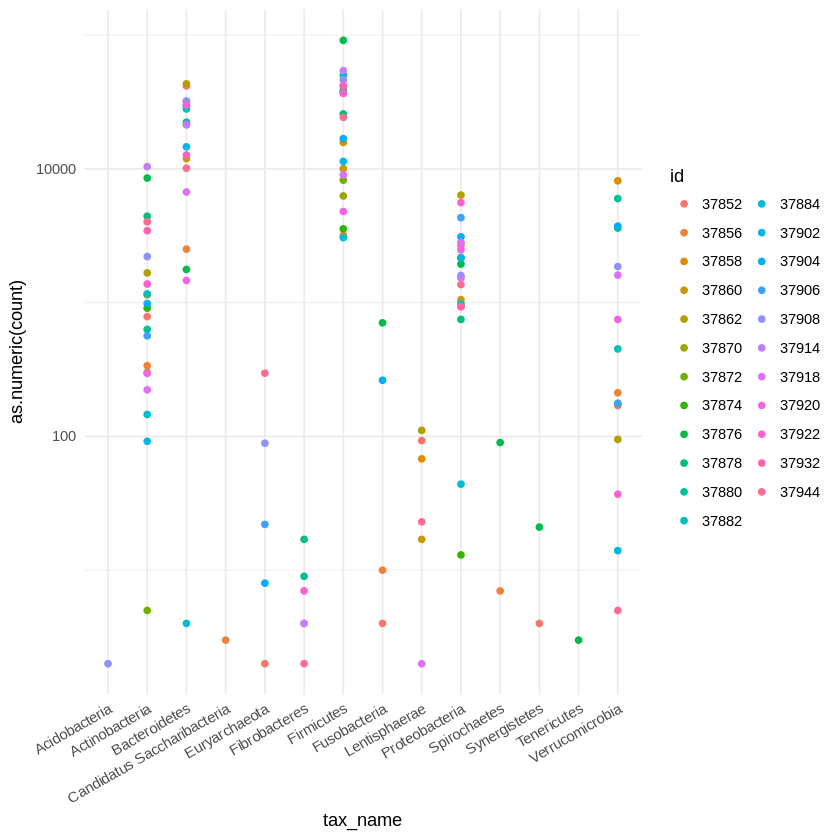

In [254]:
phyla <- public_data_table %>% filter(tax_rank == "phylum")

ggplot(phyla) +
    geom_point(aes(tax_name, as.numeric(count), colour = id)) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 30, hjust = 1)) +
    scale_y_log10()